# Paper ST Sloping - 6 beats

## Setup

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
from imblearn.metrics import classification_report_imbalanced
import random
import time

In [2]:
THREADS_TO_USE = 4

In [3]:
def parse_accuracy_per_class(conf_matrix, classes):
    acc_per_class = dict()
    for i, c in enumerate(classes):
        tn, fp, fn, tp = conf_matrix[i].ravel()
        acc_per_class[c] = (tp + tn) /(tp + tn + fp + fn)
    return acc_per_class

## Load dataset

In [4]:
data = pd.read_csv('../dataset/st_dataset_6beats.csv')
data = data.dropna()
data.head()

,id,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,...,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16,label
0,e0106,21.861233,21.421103,21.536569,6.108208,0.880920,1.079942,-0.914392,-1.844370,-1.138702,...,-0.068189,0.053454,-0.067161,0.067961,-0.093129,0.027961,-0.038417,-0.011442,0.005966,NSR
1,e0106,26.408089,27.988299,27.611772,7.776970,1.129695,1.195165,-0.806390,-1.774080,-1.792590,...,-0.031130,0.017521,-0.014034,0.023165,-0.043346,-0.016159,-0.012820,-0.007157,-0.012377,NSR
2,e0106,25.977641,26.935251,26.561891,7.477219,1.098311,1.176663,-0.849446,-1.805917,-1.623971,...,-0.025147,0.006059,-0.022267,0.043209,-0.061407,-0.003576,-0.026326,0.004760,-0.015544,NSR
3,e0106,25.189643,25.649484,25.620624,7.261496,1.066191,1.162694,-0.825414,-1.684836,-1.477246,...,-0.040045,0.024580,-0.029490,0.040770,-0.057996,-0.012361,-0.019814,0.007333,-0.030823,NSR
4,e0106,24.659920,24.559022,24.462891,6.972141,1.008067,1.143318,-0.881397,-1.797336,-1.316414,...,-0.064038,0.044904,-0.045340,0.042700,-0.063328,-0.010253,-0.004272,-0.024278,0.001717,NSR


In [5]:
data['label'].value_counts()

NSR    69911
ST-    14662
ST+     6585
Name: label, dtype: int64

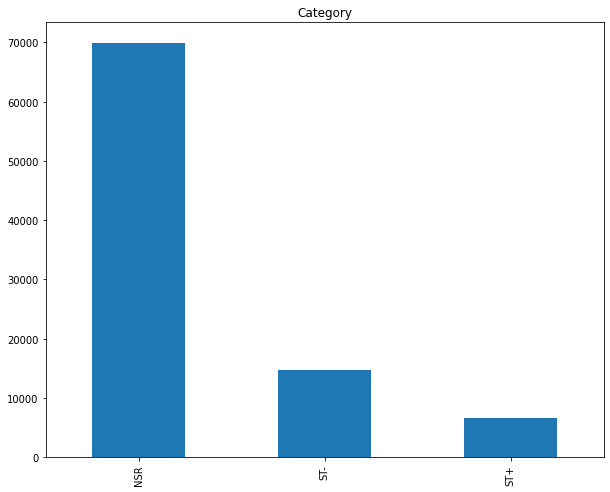

In [6]:
data['label'].value_counts().plot(kind='bar', title='Category', figsize=(10,8))
plt.show()

In [7]:
data.corr()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,mfw_5,...,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16
dw_1,1.000000,0.255941,0.126826,0.086712,0.088051,0.075713,-0.024569,0.012953,-0.001384,0.002394,...,-0.045708,-0.051747,-0.019303,-0.008486,-0.000878,-0.032264,-0.023128,-0.040651,-0.060588,-0.042833
dw_2,0.255941,1.000000,0.839774,0.443129,0.156197,0.418729,-0.461763,-0.218036,-0.003468,0.007413,...,-0.141060,0.127367,0.228143,0.164508,0.044436,0.028086,0.110780,-0.007514,-0.119066,-0.078764
dw_3,0.126826,0.839774,1.000000,0.617379,0.233068,0.346060,-0.532862,-0.300954,-0.002069,0.003404,...,-0.206438,0.110265,0.261460,0.116256,-0.047562,0.046009,0.046174,-0.030837,-0.133170,-0.047183
dw_4,0.086712,0.443129,0.617379,1.000000,0.899451,0.053813,-0.237258,-0.145344,-0.000228,0.000760,...,-0.142178,0.036774,0.117609,0.038427,-0.043639,0.039039,0.024440,-0.029533,-0.087767,-0.029773
dw_5,0.088051,0.156197,0.233068,0.899451,1.000000,-0.086599,-0.014596,-0.019561,0.000277,-0.000251,...,-0.064023,-0.004814,0.020295,0.008379,-0.014492,0.015851,0.009964,-0.028118,-0.040683,-0.015438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cfr_12,-0.032264,0.028086,0.046009,0.039039,0.015851,-0.077794,0.050496,0.076659,-0.000726,0.004327,...,-0.121386,-0.206635,-0.113087,0.008140,0.053560,1.000000,-0.006207,-0.033331,-0.303526,-0.194998
cfr_13,-0.023128,0.110780,0.046174,0.024440,0.009964,0.068140,0.004871,0.004627,0.000306,0.000798,...,0.120777,0.028507,-0.219328,-0.269074,-0.065839,-0.006207,1.000000,0.164767,0.075217,-0.175495
cfr_14,-0.040651,-0.007514,-0.030837,-0.029533,-0.028118,0.011829,0.019891,0.024541,0.001952,-0.001142,...,0.088392,0.207586,0.043674,-0.179302,-0.289882,-0.033331,0.164767,1.000000,0.131088,-0.151555
cfr_15,-0.060588,-0.119066,-0.133170,-0.087767,-0.040683,-0.021598,0.089608,0.046544,0.005107,-0.006644,...,0.251295,0.160789,-0.072934,-0.151000,-0.104688,-0.303526,0.075217,0.131088,1.000000,0.190121


In [8]:
y = data['label'].values
X = data.loc[:, ~data.columns.isin(["id", "label"])].copy()

In [9]:
label_encoder = LabelEncoder().fit(y)
y = label_encoder.transform(y)

## Feature selection

### Exclude features with corr > 0.95

In [10]:
correlated_features = set()
correlation_matrix = X.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.95:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [11]:
print(correlated_features)

{'fft_150', 'fft_145', 'fft_157', 'fft_203', 'fft_243', 'fft_238', 'mfw_11', 'fft_213', 'fft_210', 'fft_155', 'fft_212', 'fft_241', 'fft_130', 'mfw_13', 'mfw_14', 'fft_160', 'fft_218', 'fft_178', 'fft_202', 'fft_182', 'fft_235', 'fft_138', 'fft_166', 'fft_224', 'fft_209', 'fft_163', 'mfw_7', 'fft_161', 'fft_176', 'fft_181', 'fft_250', 'fft_164', 'fft_236', 'fft_146', 'fft_142', 'fft_187', 'fft_147', 'fft_168', 'fft_183', 'fft_136', 'fft_137', 'fft_200', 'mfw_5', 'fft_201', 'fft_251', 'fft_151', 'fft_216', 'fft_245', 'fft_221', 'fft_222', 'fft_239', 'fft_134', 'fft_231', 'fft_196', 'fft_237', 'fft_141', 'fft_169', 'fft_228', 'fft_135', 'fft_223', 'fft_232', 'fft_207', 'fft_175', 'mfw_10', 'fft_199', 'fft_139', 'mfw_6', 'fft_226', 'fft_171', 'fft_132', 'fft_206', 'fft_165', 'fft_186', 'fft_174', 'fft_190', 'fft_211', 'mfw_16', 'fft_177', 'fft_227', 'fft_252', 'fft_255', 'fft_197', 'fft_180', 'fft_198', 'fft_234', 'fft_173', 'fft_230', 'fft_185', 'fft_143', 'fft_256', 'fft_144', 'fft_214'

### Random forest embeded for features selection

In [12]:
cols_no_corr = [col for col in X.columns if col not in correlated_features]

In [13]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE), threshold='1.25*median')
embeded_rf_selector.fit(X[cols_no_corr], y)

SelectFromModel(estimator=RandomForestClassifier(n_jobs=4, random_state=101),
                threshold='1.25*median')

In [14]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X[cols_no_corr].loc[:,embeded_rf_support].columns.tolist()

print('\n'.join(embeded_rf_feature), '\nselected features:', len(embeded_rf_feature))

dw_1
dw_2
dw_3
dw_4
dw_5
mfw_1
mfw_2
mfw_3
mfw_4
fft_1
fft_2
fft_3
fft_4
fft_5
fft_6
fft_7
fft_8
fft_9
fft_10
fft_11
fft_12
fft_13
fft_14
fft_15
fft_16
fft_17
fft_18
fft_19
fft_20
fft_21
fft_22
fft_23
fft_24
fft_25
fft_26
fft_27
fft_28
fft_29
fft_30
fft_31
fft_32
fft_33
fft_34
fft_35
fft_36
fft_37
fft_38
ar_1
ar_2
ar_3
ar_4
ar_5
ar_6
ar_7
ar_8
ar_9
ar_10
ar_12
ar_16
var
cfr_1
cfr_2
cfr_3
cfr_4
cfr_5
cfr_6
cfr_7
cfr_8
cfr_9
cfr_10
cfr_11
cfr_12
cfr_13
cfr_14
cfr_15 
selected features: 75


### Visualization best features

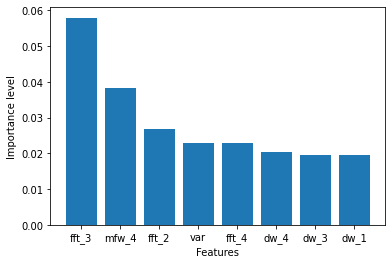

In [15]:
features_dict = dict(zip(cols_no_corr, embeded_rf_selector.estimator_.feature_importances_))
features_dict = dict(sorted(features_dict.items(), key=lambda item: item[1], reverse=True))

best_features = dict()
for index, (key, value) in enumerate(features_dict.items()):
    if index < 8:
        best_features[key] = value

plt.bar(range(len(best_features)), list(best_features.values()), align='center', )
plt.xticks(ticks=range(len(best_features)), labels=best_features.keys())
plt.xlabel('Features')
plt.ylabel('Importance level')
plt.show()

## Filter features

In [16]:
X_fsel = X[embeded_rf_feature]
X_fsel.head()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,fft_1,...,cfr_6,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15
0,21.861233,21.421103,21.536569,6.108208,0.880920,1.079942,-0.914392,-1.844370,-1.138702,-0.004752,...,0.006001,0.061446,-0.068189,0.053454,-0.067161,0.067961,-0.093129,0.027961,-0.038417,-0.011442
1,26.408089,27.988299,27.611772,7.776970,1.129695,1.195165,-0.806390,-1.774080,-1.792590,0.205786,...,0.027369,0.028651,-0.031130,0.017521,-0.014034,0.023165,-0.043346,-0.016159,-0.012820,-0.007157
2,25.977641,26.935251,26.561891,7.477219,1.098311,1.176663,-0.849446,-1.805917,-1.623971,-0.321053,...,0.008456,0.040828,-0.025147,0.006059,-0.022267,0.043209,-0.061407,-0.003576,-0.026326,0.004760
3,25.189643,25.649484,25.620624,7.261496,1.066191,1.162694,-0.825414,-1.684836,-1.477246,3.056053,...,0.029771,0.026605,-0.040045,0.024580,-0.029490,0.040770,-0.057996,-0.012361,-0.019814,0.007333
4,24.659920,24.559022,24.462891,6.972141,1.008067,1.143318,-0.881397,-1.797336,-1.316414,6.265323,...,-0.010154,0.059279,-0.064038,0.044904,-0.045340,0.042700,-0.063328,-0.010253,-0.004272,-0.024278


## Random Forest - 1000x random split

In [17]:
classes = np.unique(label_encoder.inverse_transform(y))

result_df = pd.DataFrame()

split_seeds = random.sample(range(1, 2**32 - 1), 1000)
smote_seeds = random.sample(range(1, 2**32 - 1), 1000)
for i, (split_seed, smote_seed) in enumerate(zip(split_seeds, smote_seeds)):
    start_time = time.time()

    # Train and Test split
    x_train, x_test, y_train, y_test = train_test_split(X_fsel, y, test_size=0.2, random_state=split_seed)
    smote = SMOTE(random_state=smote_seed, n_jobs=THREADS_TO_USE)
    x_smote, y_smote = smote.fit_resample(x_train, y_train)

    # Training
    model = RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE).fit(x_smote, y_smote)

    # Prediction
    y_pred = model.predict(x_test)

    # Decode
    y_test_dec = label_encoder.inverse_transform(y_test)
    y_pred_dec = label_encoder.inverse_transform(y_pred)

    # get metrics
    report = classification_report_imbalanced(y_true=y_test_dec, y_pred=y_pred_dec, labels=label_encoder.classes_, zero_division=1, output_dict=True)
    confusion_matrix = multilabel_confusion_matrix(y_pred=y_pred_dec, y_true=y_test_dec, labels=classes)

    # TOTAL
    tot_accuracy    = accuracy_score(y_true=y_test_dec, y_pred=y_pred_dec)
    tot_precision   = report['avg_pre']
    tot_recall      = report['avg_rec']
    tot_specificity = report['avg_spe']
    tot_f1          = report['avg_f1']

    # NSR
    nsr_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['NSR']
    nsr_precision   = report['NSR']['pre']
    nsr_recall      = report['NSR']['rec']
    nsr_specificity = report['NSR']['spe']
    nsr_f1          = report['NSR']['f1']

    # ST+
    st1_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['ST+']
    st1_precision   = report['ST+']['pre']
    st1_recall      = report['ST+']['rec']
    st1_specificity = report['ST+']['spe']
    st1_f1          = report['ST+']['f1']

    # ST-
    st0_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['ST+']
    st0_precision   = report['ST-']['pre']
    st0_recall      = report['ST-']['rec']
    st0_specificity = report['ST-']['spe']
    st0_f1          = report['ST-']['f1']

    # save result in result_df
    result_df = result_df.append({
        "accuracy": tot_accuracy,
        "precision": tot_precision,
        "recall": tot_recall,
        "specificity": tot_specificity,
        "f1": tot_f1,

        "nsr_accuracy": nsr_accuracy,
        "nsr_precision": nsr_precision,
        "nsr_recall": nsr_recall,
        "nsr_specificity": nsr_specificity,
        "nsr_f1": nsr_f1,

        "st+_accuracy": st1_accuracy,
        "st+_precision": st1_precision,
        "st+_recall": st1_recall,
        "st+_specificity": st1_specificity,
        "st+_f1": st1_f1,

        "st-_accuracy": st0_accuracy,
        "st-_precision": st0_precision,
        "st-_recall": st0_recall,
        "st-_specificity": st0_specificity,
        "st-_f1": st0_f1,
    }, ignore_index=True)
    end_time = time.time()

    elapsed_seconds = end_time - start_time
    # Log result
    print("#---------------------#")
    print(i+1, "of", len(split_seeds), "-", elapsed_seconds, "s")
    print("Tot: Accuracy", tot_accuracy, "Precision", tot_precision, "Recall", tot_recall, "Specificity", tot_specificity, "F1", tot_f1)
    print("NSR: Accuracy", nsr_accuracy, "Precision", nsr_precision, "Recall", nsr_recall, "Specificity", nsr_specificity, "F1", nsr_f1)
    print("ST+: Accuracy", st1_accuracy, "Precision", st1_precision, "Recall", st1_recall, "Specificity", st1_specificity, "F1", st1_f1)
    print("ST-: Accuracy", st0_accuracy, "precision", st0_precision, "Recall", st0_recall, "Specificity", st0_specificity, "F1", st0_f1)
    print("#---------------------#")

#---------------------#
1 of 1000 - 56.97074627876282 s
Tot: Accuracy 0.9354980254497587 Precision 0.9358310547385331 Recall 0.9354980254497587 Specificity 0.8960204075970557 F1 0.9355945576102239
NSR: Accuracy 0.936046511627907 Precision 0.9605755395683453 Recall 0.9557623478883321 Specificity 0.8714218676677616 F1 0.9581628991747398
ST+: Accuracy 0.984422992540588 Precision 0.8690728945506015 Recall 0.9253956292388847 Specificity 0.9890564921620822 F1 0.8963503649635037
ST-: Accuracy 0.984422992540588 precision 0.8482356971565604 Recall 0.8436115843270868 Specificity 0.9710400732169706 F1 0.8459173214895798
#---------------------#
#---------------------#
2 of 1000 - 57.67224192619324 s
Tot: Accuracy 0.9335783238262396 Precision 0.9344404108615154 Recall 0.9335783238262396 Specificity 0.8981442539343671 F1 0.933785553761997
NSR: Accuracy 0.9337977182974989 Precision 0.9607331739476925 Recall 0.9522475944276892 Specificity 0.8741291221551324 F1 0.9564715640665008
ST+: Accuracy 0.982887

In [18]:
result_df.head(10)

,accuracy,precision,recall,specificity,f1,nsr_accuracy,nsr_precision,nsr_recall,nsr_specificity,nsr_f1,st+_accuracy,st+_precision,st+_recall,st+_specificity,st+_f1,st-_accuracy,st-_precision,st-_recall,st-_specificity,st-_f1
0,0.935498,0.935831,0.935498,0.896020,0.935595,0.936047,0.960576,0.955762,0.871422,0.958163,0.984423,0.869073,0.925396,0.989056,0.896350,0.984423,0.848236,0.843612,0.971040,0.845917
1,0.933578,0.934440,0.933578,0.898144,0.933786,0.933798,0.960733,0.952248,0.874129,0.956472,0.982887,0.837500,0.939252,0.986193,0.885463,0.982887,0.854466,0.845136,0.971400,0.849775
2,0.934072,0.935284,0.934072,0.903834,0.934475,0.934840,0.963908,0.950679,0.882603,0.957248,0.984368,0.854772,0.942792,0.987589,0.896627,0.984368,0.834672,0.850904,0.967715,0.842710
3,0.935004,0.936222,0.935004,0.903271,0.935379,0.935279,0.964350,0.951171,0.881903,0.957715,0.984149,0.851678,0.949140,0.986919,0.897771,0.984149,0.837088,0.848559,0.969453,0.842785
4,0.934346,0.934834,0.934346,0.898115,0.934507,0.934950,0.960530,0.953898,0.874076,0.957203,0.984752,0.868980,0.929545,0.989061,0.898243,0.984752,0.844954,0.846077,0.969325,0.845515
5,0.933798,0.934637,0.933798,0.895960,0.934032,0.934182,0.961804,0.952503,0.872361,0.957131,0.983710,0.848966,0.940413,0.987059,0.892352,0.983710,0.840224,0.838755,0.970338,0.839489
6,0.933798,0.934487,0.933798,0.895998,0.934004,0.934127,0.961043,0.952877,0.871983,0.956943,0.983820,0.855254,0.933891,0.987704,0.892844,0.983820,0.842503,0.841924,0.970108,0.842214
7,0.937582,0.938097,0.937582,0.903699,0.937749,0.937966,0.962931,0.955528,0.881289,0.959215,0.986617,0.878853,0.942352,0.990018,0.909496,0.986617,0.848926,0.852590,0.969974,0.850754
8,0.933907,0.934999,0.933907,0.899514,0.934287,0.934291,0.963208,0.951155,0.877370,0.957144,0.984533,0.859046,0.937979,0.988125,0.896779,0.984533,0.830991,0.847256,0.967927,0.839045
9,0.934346,0.934997,0.934346,0.898560,0.934539,0.934785,0.961163,0.953235,0.874825,0.957182,0.983929,0.857538,0.934439,0.987814,0.894338,0.983929,0.846570,0.845427,0.970267,0.845998


In [19]:
print("######## Total ########")
print("Accuracy",       result_df["accuracy"].mean())
print("Precision",      result_df["precision"].mean())
print("Recall",         result_df["recall"].mean())
print("Specificity",    result_df["specificity"].mean())
print("F1",             result_df["f1"].mean())

print("######## NSR ########")
print("Accuracy",       result_df["nsr_accuracy"].mean())
print("Precision",      result_df["nsr_precision"].mean())
print("Recall",         result_df["nsr_recall"].mean())
print("Specificity",    result_df["nsr_specificity"].mean())
print("F1",             result_df["nsr_f1"].mean())

print("######## ST+ ########")
print("Accuracy",       result_df["st+_accuracy"].mean())
print("Precision",      result_df["st+_precision"].mean())
print("Recall",         result_df["st+_recall"].mean())
print("Specificity",    result_df["st+_specificity"].mean())
print("F1",             result_df["st+_f1"].mean())

print("######## ST- ########")
print("Accuracy",       result_df["st-_accuracy"].mean())
print("Precision",      result_df["st-_precision"].mean())
print("Recall",         result_df["st-_recall"].mean())
print("Specificity",    result_df["st-_specificity"].mean())
print("F1",             result_df["st-_f1"].mean())

result_df.to_csv('result/multi_6beats_smote_1000x_random_split.csv')

######## Total ########
Accuracy 0.9338035322509873
Precision 0.9345845036328257
Recall 0.9338035322509873
Specificity 0.8976618656607598
F1 0.9340365697225191
######## NSR ########
Accuracy 0.9342406208863536
Precision 0.9613985190237795
Recall 0.9525153852892663
Specificity 0.8740707607086867
F1 0.9569346851886124
######## ST+ ########
Accuracy 0.9837775888547609
Precision 0.8539677721802
Recall 0.935404806582126
Specificity 0.9875447717551952
F1 0.8927965534427112
######## ST- ########
Accuracy 0.9837775888547609
Precision 0.8427533836888866
Recall 0.8437883808039912
Specificity 0.9698498654478651
F1 0.8432449117959198
